In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, LeaveOneOut
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [127]:
class MinDistanceClassifier:
    """
    A classifier that assigns samples to the class with the nearest centroid.
    For each class, the centroid is calculated as the mean of all training samples
    belonging to that class.
    """

    def __init__(self):
        """Initialize the classifier with empty centroids dictionary."""
        self.centroids = {}

    def fit(self, X_train, y_train):
        """
        Compute centroids for each class in the training data.

        Parameters:
        -----------
        X_train : array-like of shape (n_samples, n_features)
            Training data.
        y_train : array-like of shape (n_samples,)
            Target values.

        Returns:
        --------
        self : returns an instance of self.
        """
        if not isinstance(X_train, np.ndarray):
            X_train = np.array(X_train)
        if not isinstance(y_train, np.ndarray):
            y_train = np.array(y_train)

        unique_classes = np.unique(y_train)
        for class_label in unique_classes:
            class_samples = X_train[y_train == class_label]
            if len(class_samples) == 0:
                raise ValueError(f"Class {class_label} has no samples")
            self.centroids[class_label] = np.mean(class_samples, axis=0)

        return self

    def predict(self, X_test):
        """
        Predict class labels for samples in X_test.

        Parameters:
        -----------
        X_test : array-like of shape (n_samples, n_features)
            Test samples.

        Returns:
        --------
        predictions : ndarray of shape (n_samples,)
            Predicted class label for each sample.
        """
        if not isinstance(X_test, np.ndarray):
            X_test = np.array(X_test)

        if not self.centroids:
            raise ValueError("Classifier must be fitted before making predictions")

        predictions = []
        for x in X_test:
            distances = {
                class_label: np.sqrt(np.sum((x - centroid) ** 2))
                for class_label, centroid in self.centroids.items()
            }
            predictions.append(min(distances, key=distances.get))

        return np.array(predictions)

# 1st Dataset - Whine Dataset

In [128]:
# Load wine data
whine_data = pd.read_csv("data/whine-data/wine_dataset.csv")

# Separate features and target
X = whine_data.drop("class", axis=1)
y = whine_data["class"]

count = y.value_counts()
print(count)

class
0    4898
1    1599
Name: count, dtype: int64


## Hold-Out stratify

In [129]:
# Perform stratified Hold-Out split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Balance data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normalize the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

In [130]:
# Instantiate the classifier and train
modelWhine = MinDistanceClassifier()
modelWhine.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = modelWhine.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1470
           1       0.92      0.98      0.95       480

    accuracy                           0.98      1950
   macro avg       0.96      0.98      0.97      1950
weighted avg       0.98      0.98      0.98      1950


Accuracy of the model: 0.9753846153846154




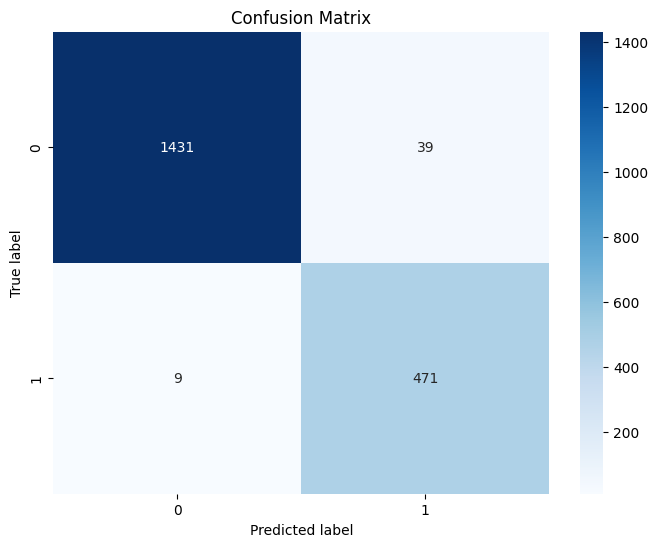

In [131]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy of the model: {accuracy}\n\n")

# Create a heatmap for the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

## Stratified K-Fold

In [132]:
modelWhine = MinDistanceClassifier()

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
overall_confusion_matrix = np.zeros((2, 2))

In [133]:
smote = SMOTE(random_state=42)
scaler = StandardScaler()

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE to the training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Normalize the resampled training data
    X_train_resampled = scaler.fit_transform(X_train_resampled)
    # Normalize the test data using the same scaler
    X_test = scaler.transform(X_test)

    modelWhine.fit(X_train_resampled, y_train_resampled)
    y_pred = modelWhine.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    fold_confusion_matrix = confusion_matrix(y_test, y_pred)
    overall_confusion_matrix += fold_confusion_matrix


Overall Accuracy of the model: 0.9807609339812728



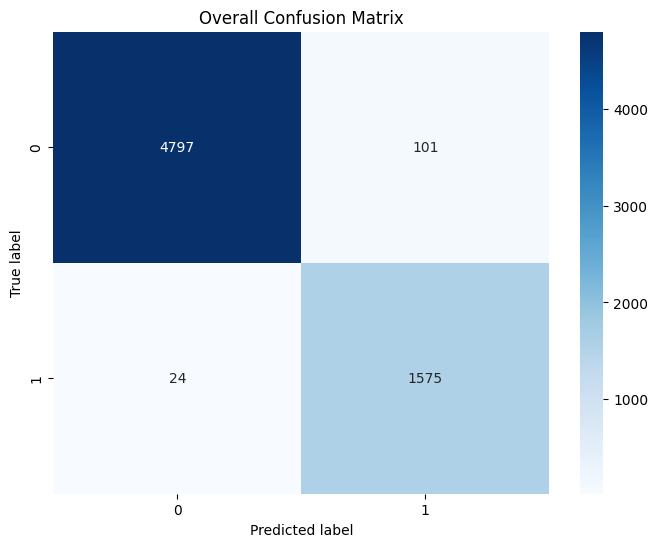

In [134]:
overall_accuracy = np.mean(accuracies)
print(f"\nOverall Accuracy of the model: {overall_accuracy}\n")

# Create a heatmap for the overall confusion matrix
plt.figure(figsize=(8, 6))

# Convert confusion matrix to integer type
overall_confusion_matrix_int = overall_confusion_matrix.astype(int)

sns.heatmap(overall_confusion_matrix_int, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Overall Confusion Matrix')
plt.show()

## Leave-One-Out

In [135]:
modelWhine = MinDistanceClassifier()

loo = LeaveOneOut()

overall_confusion_matrix = np.zeros((2, 2))
accuracies = []

In [136]:
smote = SMOTE(random_state=42)
scaler = StandardScaler()

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    X_train_resampled = scaler.fit_transform(X_train_resampled)

    X_test = scaler.transform(X_test)

    modelWhine.fit(X_train_resampled, y_train_resampled)
    y_pred = modelWhine.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    fold_confusion_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
    overall_confusion_matrix += fold_confusion_matrix


Overall Accuracy of the model: 0.9812221025088502



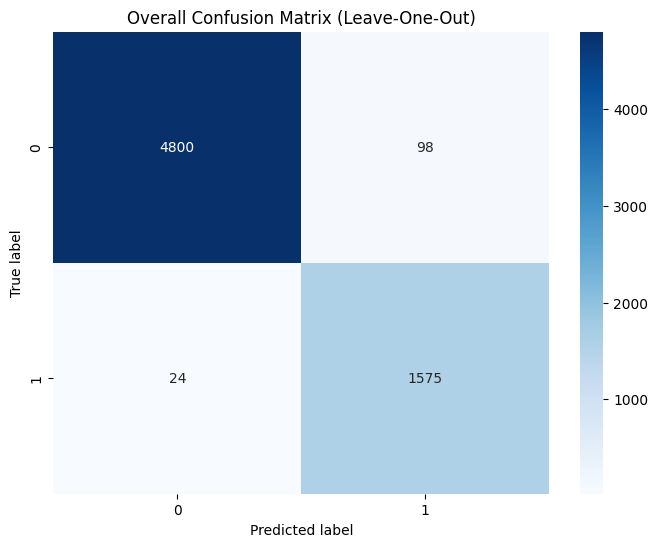

In [137]:
overall_accuracy = np.mean(accuracies)
print(f"\nOverall Accuracy of the model: {overall_accuracy}\n")

# Create a heatmap for the overall confusion matrix
plt.figure(figsize=(8, 6))

# Convert confusion matrix to integer type
overall_confusion_matrix_int = overall_confusion_matrix.astype(int)

sns.heatmap(overall_confusion_matrix_int, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0, 1], yticklabels=[0, 1])  # Specify labels
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Overall Confusion Matrix (Leave-One-Out)')
plt.show()

# 2nd Dataset - Gamma Telescope Dataset

In [138]:
gamma_data = pd.read_csv("data/GammaTelescopeData/gamma_dataset.csv")

X = gamma_data.drop("class", axis=1)
y = gamma_data["class"]

count = y.value_counts()
print(count)

class
0    12332
1     6688
Name: count, dtype: int64


## Hold-Out stratify

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)# Instantiate the classifier

In [140]:
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

modelGamma = MinDistanceClassifier()
modelGamma.fit(X_train_resampled, y_train_resampled)

y_pred = modelGamma.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      3700
           1       0.69      0.62      0.65      2006

    accuracy                           0.77      5706
   macro avg       0.75      0.73      0.74      5706
weighted avg       0.76      0.77      0.76      5706


Accuracy of the model: 0.767788293024886




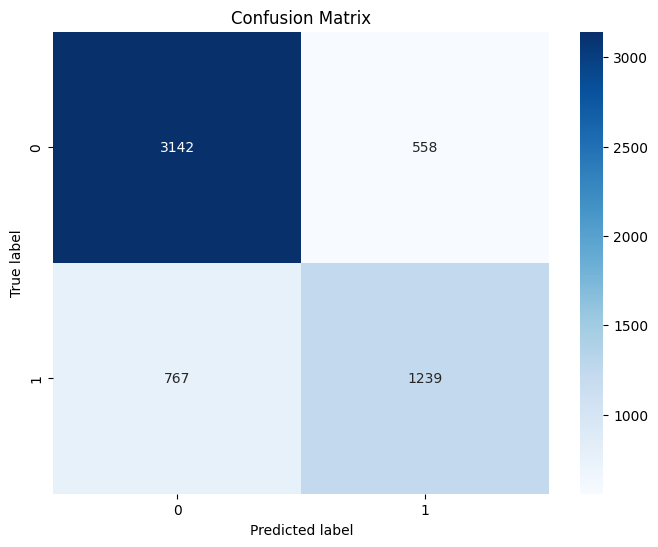

In [141]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy of the model: {accuracy}\n\n")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

## Stratified K-Fold

In [142]:
modelGamma = MinDistanceClassifier()

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
overall_confusion_matrix = np.zeros((2, 2))

In [143]:
smote = SMOTE(random_state=42)
scaler = StandardScaler()

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE to the training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Normalize the resampled training data
    X_train_resampled = scaler.fit_transform(X_train_resampled)
    # Normalize the test data using the same scaler
    X_test = scaler.transform(X_test)

    modelWhine.fit(X_train_resampled, y_train_resampled)
    y_pred = modelWhine.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    fold_confusion_matrix = confusion_matrix(y_test, y_pred)
    overall_confusion_matrix += fold_confusion_matrix


Overall Accuracy of the model: 0.7702418506834912



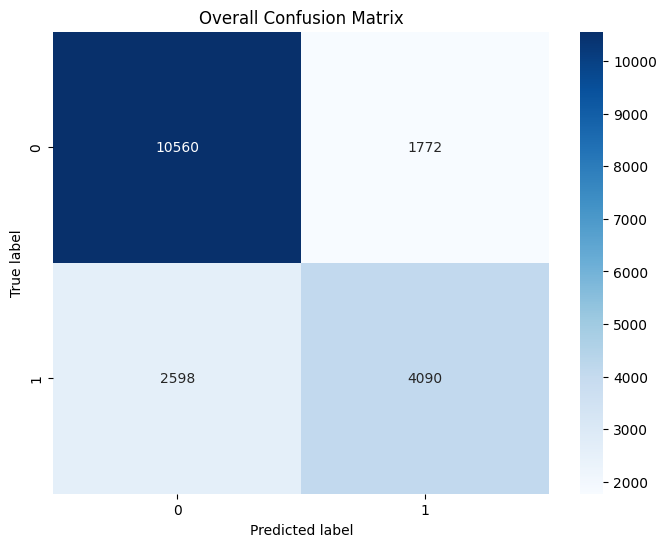

In [144]:
overall_accuracy = np.mean(accuracies)
print(f"\nOverall Accuracy of the model: {overall_accuracy}\n")

# Create a heatmap for the overall confusion matrix
plt.figure(figsize=(8, 6))

# Convert confusion matrix to integer type
overall_confusion_matrix_int = overall_confusion_matrix.astype(int)

sns.heatmap(overall_confusion_matrix_int, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Overall Confusion Matrix')
plt.show()

## Leave-One-Out

In [145]:
modelGamma = MinDistanceClassifier()

loo = LeaveOneOut()

overall_confusion_matrix = np.zeros((2, 2))
accuracies = []

In [146]:
gamma_data = pd.concat([X, y], axis=1)

sampled_data = gamma_data.groupby("class").sample(n=3000, random_state=42)


X_sampled = sampled_data.drop("class", axis=1)
y_sampled = sampled_data["class"]

print(y_sampled.value_counts())

class
0    3000
1    3000
Name: count, dtype: int64


In [147]:
smote = SMOTE(random_state=42)
scaler = StandardScaler()

for train_index, test_index in loo.split(X_sampled):
    X_train, X_test = X_sampled.iloc[train_index], X_sampled.iloc[test_index]
    y_train, y_test = y_sampled.iloc[train_index], y_sampled.iloc[test_index]

    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    X_train_resampled = scaler.fit_transform(X_train_resampled)

    X_test = scaler.transform(X_test)

    modelWhine.fit(X_train_resampled, y_train_resampled)
    y_pred = modelWhine.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    fold_confusion_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
    overall_confusion_matrix += fold_confusion_matrix


Overall Accuracy of the model: 0.7238333333333333



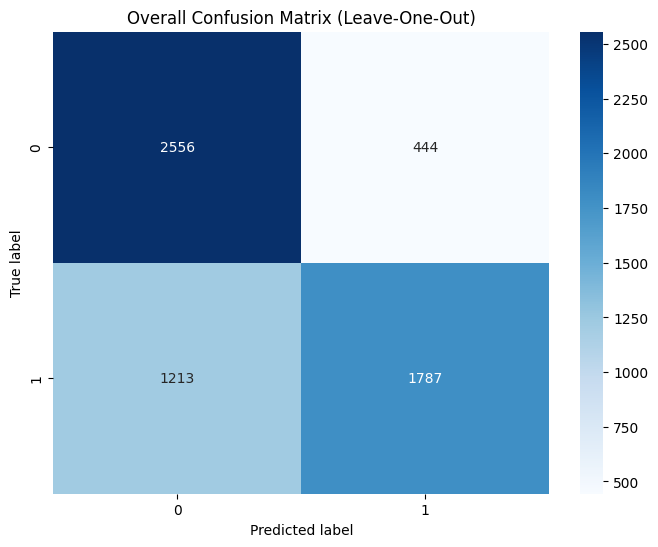

In [148]:
overall_accuracy = np.mean(accuracies)
print(f"\nOverall Accuracy of the model: {overall_accuracy}\n")

# Create a heatmap for the overall confusion matrix
plt.figure(figsize=(8, 6))

# Convert confusion matrix to integer type
overall_confusion_matrix_int = overall_confusion_matrix.astype(int)

sns.heatmap(overall_confusion_matrix_int, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0, 1], yticklabels=[0, 1])  # Specify labels
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Overall Confusion Matrix (Leave-One-Out)')
plt.show()

# 3rd Dataset - Banknote Auth Dataset

In [149]:
banknoteData = pd.read_csv("data/BanknoteAuthentication/banknote_dataset.csv")

X = banknoteData.drop("class", axis=1)
y = banknoteData["class"]

count = y.value_counts()
print(count)

class
0    762
1    610
Name: count, dtype: int64


## Hold-Out stratify

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [151]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [152]:
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

modelBanknote = MinDistanceClassifier()
modelBanknote.fit(X_train_resampled, y_train_resampled)

y_pred = modelBanknote.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       229
           1       0.83      0.86      0.84       183

    accuracy                           0.86       412
   macro avg       0.85      0.86      0.86       412
weighted avg       0.86      0.86      0.86       412


Accuracy of the model: 0.8567961165048543




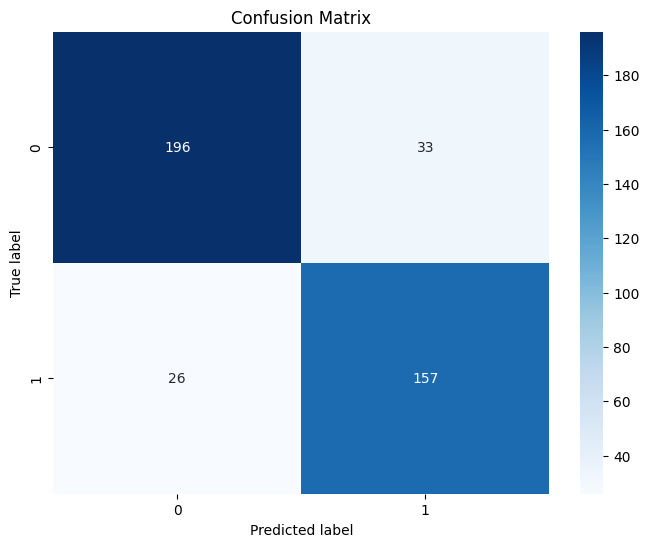

In [153]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy of the model: {accuracy}\n\n")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

## Stratified K-Fold

In [154]:
modelBanknote = MinDistanceClassifier()

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
overall_confusion_matrix = np.zeros((2, 2))

In [155]:
smote = SMOTE(random_state=42)
scaler = StandardScaler()

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE to the training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Normalize the resampled training data
    X_train_resampled = scaler.fit_transform(X_train_resampled)
    # Normalize the test data using the same scaler
    X_test = scaler.transform(X_test)

    modelWhine.fit(X_train_resampled, y_train_resampled)
    y_pred = modelWhine.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    fold_confusion_matrix = confusion_matrix(y_test, y_pred)
    overall_confusion_matrix += fold_confusion_matrix


Overall Accuracy of the model: 0.8477150111075848



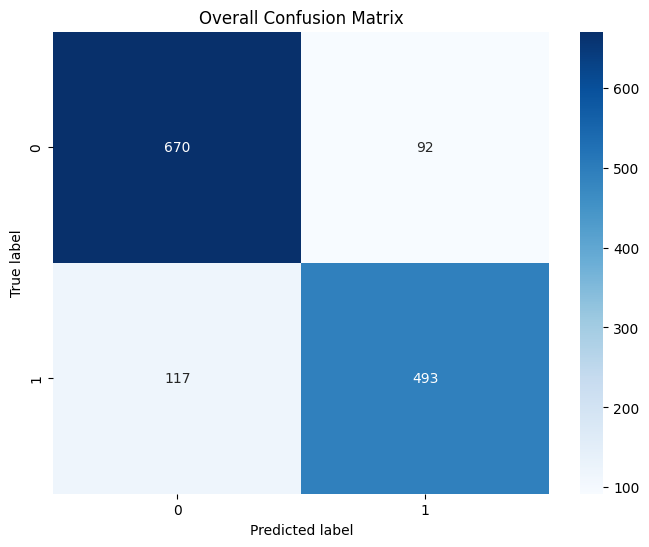

In [156]:
overall_accuracy = np.mean(accuracies)
print(f"\nOverall Accuracy of the model: {overall_accuracy}\n")

# Create a heatmap for the overall confusion matrix
plt.figure(figsize=(8, 6))

# Convert confusion matrix to integer type
overall_confusion_matrix_int = overall_confusion_matrix.astype(int)

sns.heatmap(overall_confusion_matrix_int, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Overall Confusion Matrix')
plt.show()

## Leave-One-Out

In [157]:
modelBanknote = MinDistanceClassifier()

loo = LeaveOneOut()

overall_confusion_matrix = np.zeros((2, 2))
accuracies = []

In [158]:
smote = SMOTE(random_state=42)
scaler = StandardScaler()

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    X_train_resampled = scaler.fit_transform(X_train_resampled)

    X_test = scaler.transform(X_test)

    modelWhine.fit(X_train_resampled, y_train_resampled)
    y_pred = modelWhine.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    fold_confusion_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
    overall_confusion_matrix += fold_confusion_matrix


Overall Accuracy of the model: 0.8454810495626822



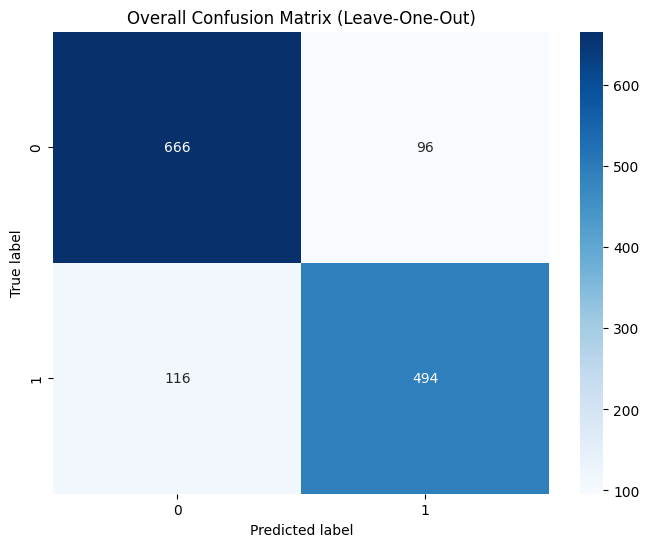

In [159]:
overall_accuracy = np.mean(accuracies)
print(f"\nOverall Accuracy of the model: {overall_accuracy}\n")

# Create a heatmap for the overall confusion matrix
plt.figure(figsize=(8, 6))

# Convert confusion matrix to integer type
overall_confusion_matrix_int = overall_confusion_matrix.astype(int)

sns.heatmap(overall_confusion_matrix_int, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0, 1], yticklabels=[0, 1])  # Specify labels
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Overall Confusion Matrix (Leave-One-Out)')
plt.show()